
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Iterations: 1 , Total time 0.1
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Iterations: 2 , Total time 0.2
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in err

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational p

Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in err

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Solving linear variational problem.
Solving linear variational problem.
*** Warning: Degree of exact solution may be inadequate for accurate result in err

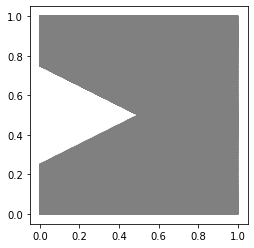

In [1]:
# Preliminaries and mesh
import meshio
mesh_from_file = meshio.read("/mnt/d/Research Projects/FEniCS/crack_movement/2d.msh")

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("/mnt/d/Research Projects/FEniCS/crack_movement/2d.xdmf", triangle_mesh)

from dolfin import *
import matplotlib.pyplot as plt

mesh = Mesh()
with XDMFFile("/mnt/d/Research Projects/FEniCS/crack_movement/2d.xdmf") as infile:
    infile.read(mesh)

plot(mesh);

# Define Space
V = FunctionSpace(mesh, 'CG', 1)
W = VectorFunctionSpace(mesh, 'CG', 1)
WW = FunctionSpace(mesh, 'DG', 0)
p, q = TrialFunction(V), TestFunction(V)
u, v = TrialFunction(W), TestFunction(W)

# Introduce manually the material parameters
Gc =  2.7
l = 2*mesh.hmin()
lmbda = 121.1538e3
mu = 80.7692e3

# Constituive functions
def epsilon(u):
    return sym(grad(u))
def sigma(u):
    return 2.0*mu*epsilon(u)+lmbda*tr(epsilon(u))*Identity(len(u))
def psi(u):
    return 0.5*(lmbda+mu)*(0.5*(tr(epsilon(u))+abs(tr(epsilon(u)))))**2+\
           mu*inner(dev(epsilon(u)),dev(epsilon(u)))
def H(uold,unew,Hold):
    return conditional(lt(psi(uold),psi(unew)),psi(unew),Hold)

# Boundary conditions
top = CompiledSubDomain("near(x[1], 1., 1e-6) && on_boundary")
bot = CompiledSubDomain("near(x[1], 0., 1e-6) && on_boundary")

load = Expression("t", t = 0.0, degree=1)
bcbot= DirichletBC(W, Constant((0.0,0.0)), bot)
bctop = DirichletBC(W.sub(1), load, top)
bc_u = [bcbot, bctop]
bc_phi = [ ]
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
top.mark(boundaries,1)
ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)

# Variational form
unew, uold = Function(W, name = 'disp'), Function(W)
pnew, pold, Hold = Function(V, name = 'phi'), Function(V), Function(V)
E_du = ((1.0-pold)**2)*inner(grad(v),sigma(u))*dx
E_phi = (Gc*l*inner(grad(p),grad(q))+((Gc/l)+2.0*H(uold,unew,Hold))\
            *inner(p,q)-2.0*H(uold,unew,Hold)*q)*dx
p_disp = LinearVariationalProblem(lhs(E_du), rhs(E_du), unew, bc_u)
p_phi = LinearVariationalProblem(lhs(E_phi), rhs(E_phi), pnew, bc_phi)
solver_disp = LinearVariationalSolver(p_disp)
solver_phi = LinearVariationalSolver(p_phi)

# Initialization of the iterative procedure and output requests
t = 0
u_r = 0.007
deltaT  = 0.1
tol = 1e-3
file_results = XDMFFile("crack.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

# Staggered scheme
while t<=1.0:
    t += deltaT
#     if t >=0.7:
#         deltaT = 0.0001
    load.t=t*u_r
    iter = 0
    err = 1

    while err > tol:
        iter += 1
        solver_disp.solve()
        solver_phi.solve()
        err_u = errornorm(unew,uold,norm_type = 'l2',mesh = None)
        err_phi = errornorm(pnew,pold,norm_type = 'l2',mesh = None)
        err = max(err_u,err_phi)
        
        uold.assign(unew)
        pold.assign(pnew)
        Hold.assign(project(psi(unew), WW))

        if err < tol:

            print ('Iterations:', iter, ', Total time', t)

            if round(t*1e4) % 10 == 0:
                file_results.write(pnew, 0.)
                file_results.write(unew, 0.)
print ('Simulation completed') 



Cell 1: (0.08377165240967861, 0.9672033351187815)
Cell 2: (0.0837716524096788, 0.032796664881218594)
Cell 3: (0.6429908293399414, 0.3141284033028074)
Cell 4: (0.7366377431269334, 0.3222517861472824)
Cell 5: (0.49498169107904016, 0.9708571056600538)
Cell 6: (0.49498169107903967, 0.029142894339945935)
Cell 7: (0.5302074026769156, 0.9433603260979061)
Cell 8: (0.5302074026769154, 0.05663967390209357)
Cell 9: (0.6178793098204499, 0.8197636790090971)
Cell 10: (0.4391805897084155, 0.7468505478046099)
Cell 11: (0.4430978094646117, 0.38089532381358376)
Cell 12: (0.7279595269021955, 0.3572810411398035)
Cell 13: (0.35422491953654855, 0.3863134197784557)
Cell 14: (0.3525020708032929, 0.3802741446544229)
Cell 15: (0.7444197917113846, 0.6467249201677596)
Cell 16: (0.5316862493838888, 0.47771210099528033)
Cell 17: (0.2776784424848065, 0.9535475944304409)
Cell 18: (0.27767844248480683, 0.04645240556955832)
Cell 19: (0.5355336800540402, 0.4745282437704061)
Cell 20: (0.8555342661824842, 0.3299752822254

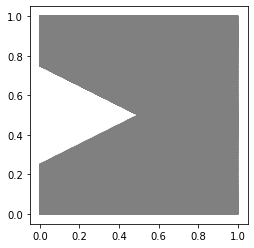

In [4]:
import meshio
mesh_from_file = meshio.read("/mnt/d/Research Projects/FEniCS/crack_movement/2d.msh")

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("/mnt/d/Research Projects/FEniCS/crack_movement/2d.xdmf", triangle_mesh)

from dolfin import *
import matplotlib.pyplot as plt

mesh = Mesh()
with XDMFFile("/mnt/d/Research Projects/FEniCS/crack_movement/2d.xdmf") as infile:
    infile.read(mesh)

plot(mesh);
from dolfin import *

# Load the mesh from the XDMF file
mesh = Mesh()
with XDMFFile("/mnt/d/Research Projects/FEniCS/crack_movement/2d.xdmf") as infile:
    infile.read(mesh)

# Get the cell midpoint coordinates and indices
midpoints = []
for i, cell in enumerate(cells(mesh)):
    midpoint = cell.midpoint().x(), cell.midpoint().y()
    midpoints.append((i+1, midpoint))  # Store index and midpoint together

# Print the cell midpoint coordinates and indices
for index, midpoint in midpoints:
    print(f"Cell {index}: {midpoint}")
